In [ ]:
#|default_exp tmp

In [1]:
import timm

In [3]:
timm.list_models("resnet*")

['resnet10t',
 'resnet14t',
 'resnet18',
 'resnet18d',
 'resnet26',
 'resnet26d',
 'resnet26t',
 'resnet32ts',
 'resnet33ts',
 'resnet34',
 'resnet34d',
 'resnet50',
 'resnet50_gn',
 'resnet50d',
 'resnet50t',
 'resnet51q',
 'resnet61q',
 'resnet101',
 'resnet101d',
 'resnet152',
 'resnet152d',
 'resnet200',
 'resnet200d',
 'resnetaa50',
 'resnetaa50d',
 'resnetaa101d',
 'resnetblur18',
 'resnetblur50',
 'resnetblur50d',
 'resnetblur101d',
 'resnetrs50',
 'resnetrs101',
 'resnetrs152',
 'resnetrs200',
 'resnetrs270',
 'resnetrs350',
 'resnetrs420',
 'resnetv2_50',
 'resnetv2_50d',
 'resnetv2_50d_evob',
 'resnetv2_50d_evos',
 'resnetv2_50d_frn',
 'resnetv2_50d_gn',
 'resnetv2_50t',
 'resnetv2_50x1_bit_distilled',
 'resnetv2_50x1_bitm',
 'resnetv2_50x1_bitm_in21k',
 'resnetv2_50x3_bitm',
 'resnetv2_50x3_bitm_in21k',
 'resnetv2_101',
 'resnetv2_101d',
 'resnetv2_101x1_bitm',
 'resnetv2_101x1_bitm_in21k',
 'resnetv2_101x3_bitm',
 'resnetv2_101x3_bitm_in21k',
 'resnetv2_152',
 'resnetv2_152

# Mixup

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [ ]:
# speed mods
from miniai.utils import *

MetricsCB = LazyMetricsCB
ProgressCB = LazyProgressCB

In [ ]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
class Dropout(nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p

    def forward(self, x):
        if not self.training: return x
        dist = distributions.binomial.Binomial(tensor(1.0).to(x.device), probs=1-self.p)
        return x * dist.sample(x.size()) * 1/(1-self.p)

In [ ]:
#Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
#https://arxiv.org/abs/1908.08681v1
#implemented for PyTorch / FastAI by lessw2020 
#github: https://github.com/lessw2020/mish

class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 256
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
tds.cached = cache_dataset_as_dict(tds)

In [ ]:
def get_model9(act=nn.ReLU, nfs=(32,288,288,288,288,288), norm=nn.BatchNorm2d):#,256
    layers = [ResBlock(1, 32, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [ ]:
from torchvision import transforms

In [ ]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

In [ ]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [ ]:
#| export
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_preds,self.all_targs = [],[]
    def after_batch(self, learn):
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))
    def after_fit(self, learn): self.all_preds,self.all_targs = torch.cat(self.all_preds),torch.cat(self.all_targs)

In [ ]:
#| export
@fc.patch
def capture_preds(self: Learner, cbs=None):
    cp = CapturePreds()
    self.fit(1, train=False, cbs=[cp]+fc.L(cbs))
    return cp.all_preds,cp.all_targs

# No currriculurm learning 

In [ ]:
dls = DataLoaders.from_dd(tds.cached, bs, num_workers=0)

# tweaked from rohitgeo's version
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics] 
#0.0003 from https://github.com/digantamisra9

In [ ]:
def upscale_cb(scale, mode='bilinear'): 
    return BatchTransformCB(lambda b: (F.interpolate(b[0], scale_factor=scale, mode=mode),b[1]),
                            on_val=True, on_train=True)

In [ ]:
import timm

In [ ]:
def run(model, leaky=0.0003, seed=1, m=1, cbs=tuple(), train_cb=TrainCB(), epochs=5, lr_base=2e-2):
    set_seed(seed)
    iw = partial(init_weights, leaky=leaky) if leaky is not None else fc.noop
    lr = lr_base*m
    print("Batch size", bs*m)
    dls = DataLoaders.from_dd(tds.cached, bs*m, num_workers=0)
    tmax = epochs * len(dls.train)
    sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
    cbs = [DeviceCB(), metrics, BatchSchedCB(sched), *cbs, train_cb] 
   
    learn = Learner(model.apply(iw), dls, F.cross_entropy, lr=lr, cbs=cbs, opt_func=optim.AdamW)
    learn.fit(epochs, cbs=[TimeItCB(), ProgressCB(plot=True)])
    
    
    ## TTA
    ap1, at = learn.capture_preds()
    ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
    ap2, at = learn.capture_preds(cbs=[ttacb])
    ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
    print('TTA:', round((ap==at).float().mean().item(), 4))
    
    return learn

## Timm resnet upscale

Batch size 256


accuracy,loss,epoch,train
0.814,0.563,0,train
0.503,2.700,0,eval
0.904,0.269,1,train
0.899,0.284,1,eval
0.929,0.196,2,train
0.920,0.224,2,eval
0.950,0.138,3,train
0.939,0.176,3,eval
0.971,0.080,4,train
0.944,0.170,4,eval


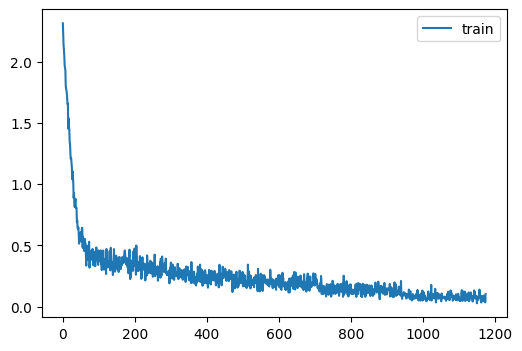

Fit 5 in: 138.36s, setup: 0.00s, 25.78 ± 0.03s per epoch, 0.03 ± 0.01s per batch
TTA: 0.9389


In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, 
            leaky=0.0003, cbs=[upscale_cb(4, 'nearest')])

## [90.8 / 94.4] with General RELU

In [ ]:
set_seed(1)

act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1) 

epochs = 5
lr = 1e-2
tmax = epochs * len(dls.train)
schedb = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

accuracy,loss,epoch,train
0.872,0.563,0,train
0.899,0.431,0,eval
0.912,0.383,1,train
0.905,0.345,1,eval
0.917,0.307,2,train
0.893,0.342,2,eval
0.923,0.258,3,train
0.885,0.353,3,eval
0.928,0.226,4,train
0.914,0.257,4,eval


Fit 5 in: 125.42s, setup: 0.00s, 23.99 ± 0.21s per epoch, 0.01 ± 0.00s per batch


Batch size 256


accuracy,loss,epoch,train
0.816,0.552,0,train
0.791,0.604,0,eval
0.901,0.276,1,train
0.894,0.302,1,eval
0.926,0.203,2,train
0.922,0.231,2,eval
0.948,0.145,3,train
0.937,0.175,3,eval
0.967,0.092,4,train
0.944,0.161,4,eval


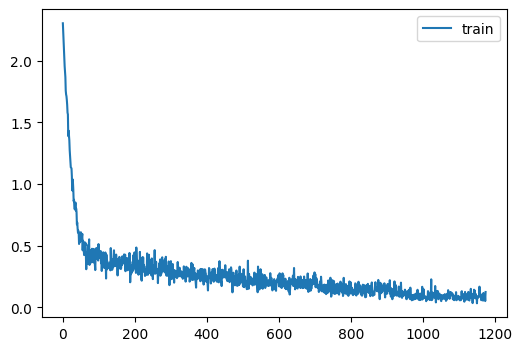

Fit 5 in: 137.62s, setup: 0.00s, 25.64 ± 0.14s per epoch, 0.03 ± 0.01s per batch
TTA: 0.9352


In [ ]:
def act_gr(*args,**kw): return GeneralRelu(leak=0.1, sub=0.4)
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=act_gr, pretrained=False), m=1, 
            leaky=0.1, cbs=[upscale_cb(4, 'nearest')])

Batch size 256


accuracy,loss,epoch,train
0.811,0.568,0,train
0.800,0.560,0,eval
0.894,0.297,1,train
0.856,0.433,1,eval
0.920,0.225,2,train
0.921,0.226,2,eval
0.944,0.159,3,train
0.937,0.183,3,eval
0.962,0.105,4,train
0.943,0.167,4,eval


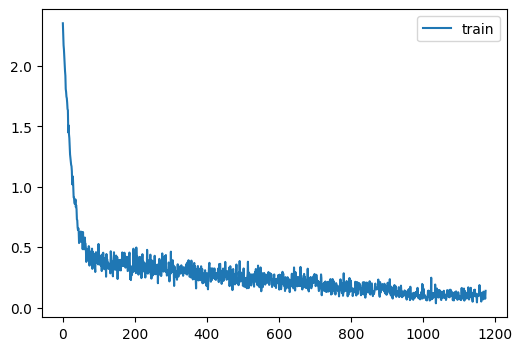

Fit 5 in: 138.42s, setup: 0.00s, 25.80 ± 0.03s per epoch, 0.03 ± 0.00s per batch
TTA: 0.9362


In [ ]:

def act_gr(*args,**kw): return GeneralRelu(leak=0.1, sub=0.4)
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=act_gr, pretrained=False, drop_rate=0.4), m=1, 
            leaky=0.1, cbs=[upscale_cb(4, 'nearest')])

### [94.4] Resnet18d RELU

Batch size 256


accuracy,loss,epoch,train
0.817,0.537,0,train
0.683,0.948,0,eval
0.904,0.267,1,train
0.866,0.384,1,eval
0.930,0.195,2,train
0.922,0.219,2,eval
0.951,0.138,3,train
0.939,0.176,3,eval
0.972,0.081,4,train
0.944,0.160,4,eval


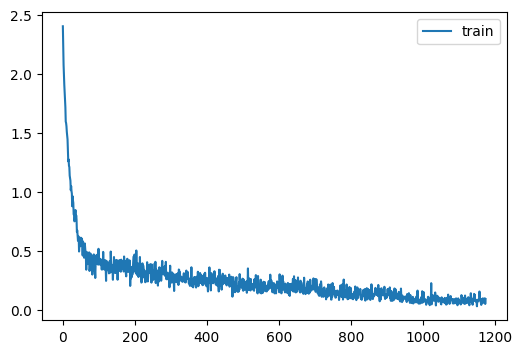

Fit 5 in: 133.80s, setup: 0.00s, 24.86 ± 0.10s per epoch, 0.02 ± 0.01s per batch
TTA: 0.9392


In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, pretrained=False), m=1, 
            leaky=0.0, cbs=[upscale_cb(4, 'nearest')])

## [93.5] With mish

In [ ]:
set_seed(1)
act_gr = Mish
iw = partial(init_weights, leaky=0.0003)
epochs = 5
lr = 1e-2
tmax = epochs * len(dls.train)
schedb = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

accuracy,loss,epoch,train
0.877,0.560,0,train
0.894,0.443,0,eval
0.914,0.377,1,train
0.906,0.346,1,eval
0.923,0.292,2,train
0.899,0.325,2,eval
0.929,0.242,3,train
0.902,0.289,3,eval
0.937,0.202,4,train
0.920,0.243,4,eval


Fit 5 in: 138.43s, setup: 0.00s, 26.52 ± 0.03s per epoch, 0.01 ± 0.00s per batch


## [93.4 / 94.5] with Hardswish

In [ ]:
set_seed(1)
act_gr = nn.Hardswish
iw = partial(init_weights, leaky=0.0003)
epochs = 5
lr = 1e-2
tmax = epochs * len(dls.train)
schedb = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

accuracy,loss,epoch,train
0.872,0.570,0,train
0.897,0.435,0,eval
0.914,0.380,1,train
0.906,0.351,1,eval
0.923,0.295,2,train
0.900,0.320,2,eval
0.929,0.242,3,train
0.910,0.269,3,eval
0.937,0.204,4,train
0.918,0.255,4,eval


Fit 5 in: 121.84s, setup: 0.00s, 23.36 ± 0.04s per epoch, 0.01 ± 0.00s per batch


Batch size 256


accuracy,loss,epoch,train
0.808,0.582,0,train
0.707,1.127,0,eval
0.904,0.271,1,train
0.876,0.338,1,eval
0.928,0.197,2,train
0.919,0.227,2,eval
0.951,0.135,3,train
0.937,0.179,3,eval
0.972,0.079,4,train
0.945,0.170,4,eval


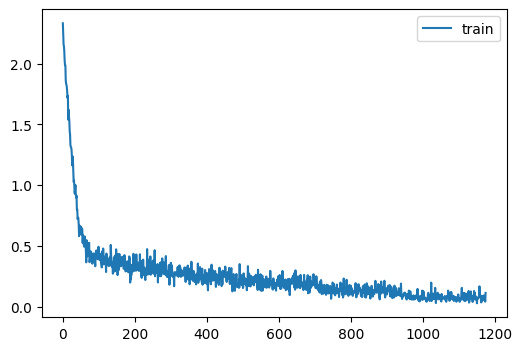

Fit 5 in: 135.28s, setup: 0.00s, 25.16 ± 0.01s per epoch, 0.02 ± 0.00s per batch
TTA: 0.9378


In [ ]:
def act_gr(*args,**kw): return nn.Hardswish()
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=act_gr, pretrained=False), m=1, 
            leaky=0.0003, cbs=[upscale_cb(4, 'nearest')])

Batch size 256


accuracy,loss,epoch,train
0.799,0.604,0,train
0.793,0.580,0,eval
0.900,0.281,1,train
0.908,0.262,1,eval
0.924,0.209,2,train
0.921,0.216,2,eval
0.948,0.145,3,train
0.938,0.177,3,eval
0.969,0.088,4,train
0.943,0.168,4,eval


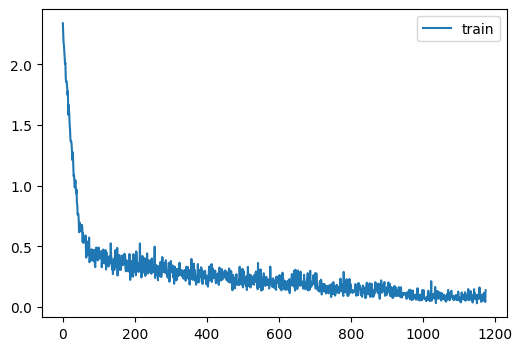

Fit 5 in: 135.24s, setup: 0.00s, 25.18 ± 0.02s per epoch, 0.02 ± 0.00s per batch
TTA: 0.9363


In [ ]:
def act_gr(*args,**kw): return nn.Hardswish()
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=act_gr, pretrained=False, drop_rate=0.4), m=1, 
            leaky=0.0003, cbs=[upscale_cb(4, 'nearest')])

## [93.3 / 94.4] With silu

In [ ]:
set_seed(1)
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 5
lr = 1e-2
tmax = epochs * len(dls.train)
schedb = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

accuracy,loss,epoch,train
0.875,0.562,0,train
0.895,0.448,0,eval
0.914,0.377,1,train
0.907,0.337,1,eval
0.924,0.293,2,train
0.892,0.345,2,eval
0.930,0.241,3,train
0.911,0.268,3,eval
0.936,0.202,4,train
0.914,0.256,4,eval


Fit 5 in: 120.42s, setup: 0.00s, 23.09 ± 0.15s per epoch, 0.01 ± 0.00s per batch


In [ ]:
set_seed(1)
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 5
lr = 1e-2
tmax = epochs * len(dls.train)
schedb = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), MixUpCB(0.4)] 
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

accuracy,loss,epoch,train
0.479,0.900,0,train
0.896,0.463,0,eval
0.511,0.779,1,train
0.909,0.374,1,eval
0.493,0.695,2,train
0.904,0.353,2,eval
0.516,0.643,3,train
0.905,0.318,3,eval
0.507,0.603,4,train
0.921,0.278,4,eval


Fit 5 in: 128.93s, setup: 0.00s, 24.73 ± 0.13s per epoch, 0.01 ± 0.00s per batch


Batch size 256


accuracy,loss,epoch,train
0.813,0.560,0,train
0.692,0.992,0,eval
0.907,0.263,1,train
0.909,0.256,1,eval
0.928,0.196,2,train
0.924,0.216,2,eval
0.951,0.136,3,train
0.940,0.171,3,eval
0.972,0.080,4,train
0.944,0.164,4,eval


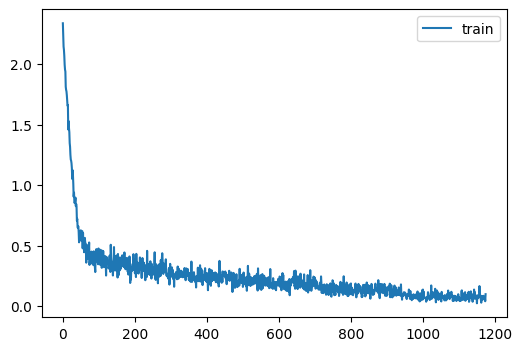

Fit 5 in: 135.44s, setup: 0.00s, 25.21 ± 0.04s per epoch, 0.02 ± 0.00s per batch
TTA: 0.9381


In [ ]:
def act_gr(*args,**kw): return nn.SiLU()
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=act_gr, pretrained=False), m=1, 
            leaky=0.0003, cbs=[upscale_cb(4, 'nearest')])

Batch size 256


accuracy,loss,epoch,train
0.808,0.579,0,train
0.564,2.152,0,eval
0.901,0.279,1,train
0.895,0.297,1,eval
0.925,0.206,2,train
0.928,0.205,2,eval
0.948,0.144,3,train
0.941,0.171,3,eval
0.969,0.088,4,train
0.944,0.165,4,eval


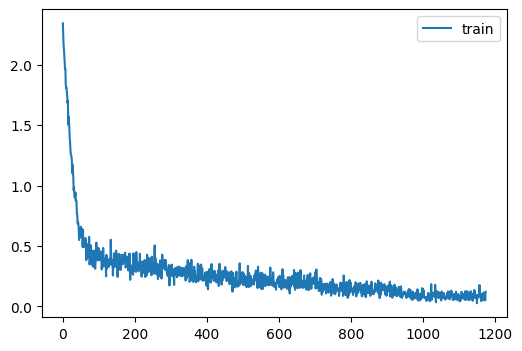

Fit 5 in: 135.40s, setup: 0.00s, 25.21 ± 0.01s per epoch, 0.02 ± 0.00s per batch
TTA: 0.938


In [ ]:
def act_gr(*args,**kw): return nn.SiLU()
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=act_gr, pretrained=False, drop_rate=0.4), m=1, 
            leaky=0.0003, cbs=[upscale_cb(4, 'nearest')])

# MixUp

In [ ]:
xb,yb = fc.first(dls.train)

In [ ]:
def mixup_data(x, y, dist=torch.distributions.Beta(tensor(1), tensor(1))):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    lam = dist.sample().to(x.device)
    batch_size = x.shape[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, (y_a, y_b, lam)


mx, my = mixup_data(xb.to(def_device), yb.to(def_device), torch.distributions.Beta(0.4, .4))
mx.device, [y.device for y in my], my[-1]

(device(type='cuda', index=0),
 [device(type='cuda', index=0),
  device(type='cuda', index=0),
  device(type='cuda', index=0)],
 tensor(0.61, device='cuda:0'))

(torch.Size([256, 1, 28, 28]),
 [torch.Size([256]), torch.Size([256]), torch.Size([])],
 tensor(0.61, device='cuda:0'))

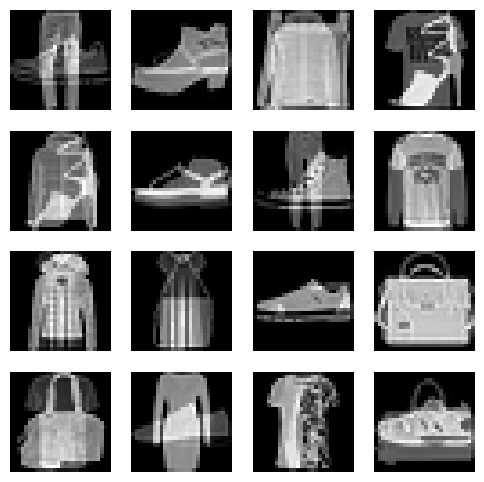

In [ ]:
show_images(mx[:16],imsize=1.5)
mx.shape, [y.shape for y in my], my[-1]

In [ ]:
def mixup_criterion(lf, pred, my):
    y_a, y_b, lam = my
    return lam * lf(pred, y_a) + (1 - lam) * lf(pred, y_b)

In [ ]:
with torch.no_grad():
    preds = get_model9().to(def_device).eval()(mx)
    print(mixup_criterion(F.cross_entropy, preds, my))

tensor(2.31, device='cuda:0')


In [ ]:
TrainCB??

Init signature: TrainCB(n_inp=1)
Docstring:      <no docstring>
Source:        
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()
File:           ~/workspace/part2/course22p2/miniai/learner.py
Type:           type
Subclasses:     MixUpCB

In [ ]:
class MixUpCB(TrainCB):
    def __init__(self,alpha=0.4, mix_data=mixup_data, mix_loss=mixup_criterion,**kw): 
        super().__init__(**kw)
        self.alpha = alpha
        self.mix_data = mix_data
        self.mix_loss = mix_loss
        
    def before_fit(self, learn):
        self.base_lf = learn.loss_func
        
    def dist(self): return torch.distributions.Beta(self.alpha,self.alpha) 
    
    def before_batch(self, learn):
        if learn.training and self.alpha is not None: 
            bx, mixup = self.mix_data(*learn.batch, self.dist())
            learn.batch = bx, learn.batch[1]
            learn.mixup = mixup

    def get_loss(self, learn):
        if learn.training and self.alpha is not None:
            learn.loss = self.mix_loss(learn.loss_func, learn.preds, learn.mixup) # todo  *learn.batch[self.n_inp:]   
        else:
            super().get_loss(learn)

(torch.Size([256, 1, 28, 28]),
 torch.Size([256, 10]),
 tensor([[0.00, 0.10, 0.90, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 1.00],
         [0.00, 0.00, 0.00, 0.00, 0.00, 0.99, 0.00, 0.01, 0.00, 0.00]], device='cuda:0'))

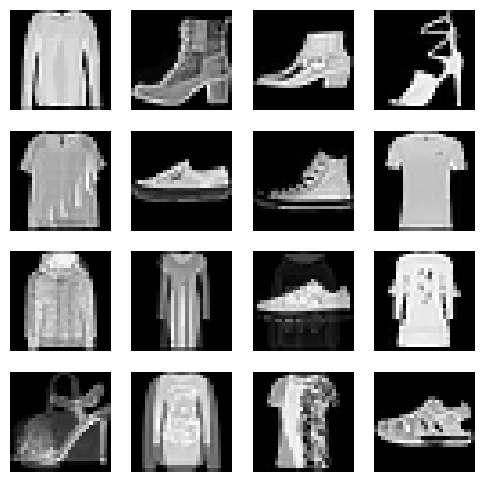

In [ ]:
def mixup_data2(x, y, dist=torch.distributions.Beta(tensor(1.0), tensor(1.0)), classes=10, return_lam=False):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    batch_size = x.shape[0]
    lam = dist.sample([batch_size]).to(x.device)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = torch.lerp(x, x[index], lam.reshape(-1,1,1,1))
    y = F.one_hot(y, num_classes=classes)
    
    mixed_y = y + lam.reshape(-1,1)*(y[index]-y)
    #mixed_y = torch.lerp(y, y[index], lam.reshape(-1,1))
    if return_lam:
        return mixed_x, mixed_y, lam
    return mixed_x, mixed_y,

mx, my, lam  = mixup_data2(xb.to(def_device), yb.to(def_device), dist=torch.distributions.Beta(0.4, .4), return_lam=True)

show_images(mx[:16],imsize=1.5)
mx.shape, my.shape, my[:4]

In [ ]:
# sanity check if values are correctly distributed over 1hot verctors
for y, l in zip(my, lam):
    nonzeros = y[y.nonzero()].flatten()
    if nonzeros.shape[0] == 1: continue
    lc = nonzeros.min()
    if l > 0.5: lc=1-lc
    if (l - lc).abs() >0.001:
        print(l,lc, y)

In [ ]:
with torch.no_grad():
    preds = get_model9().to(def_device).eval()(mx)
    print(F.cross_entropy(preds, my))

tensor(2.30, device='cuda:0')


## Beta distribution


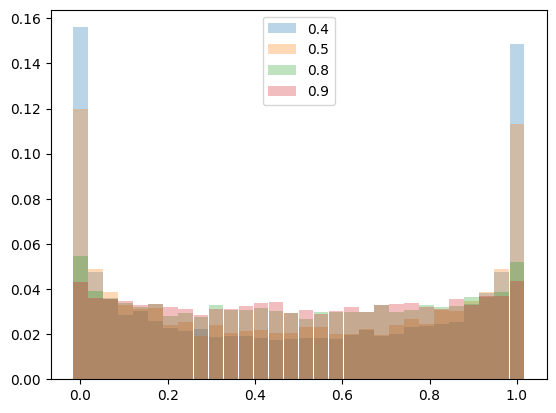

In [ ]:
def plot_beta(alpha,bars=30):
    sz = 10000
    dist = torch.distributions.Beta(alpha,alpha)
    x = torch.linspace(0, 1, bars)
    histc = dist.sample([sz]).histc(bins=x.shape[-1])/sz
    plt.bar(x, histc, width=1/bars, alpha=0.3, label='a')
    plt.legend([f'{v:.3}' for v in alphas])


alphas = [0.4 ,0.5, 0.8, 0.9]
for alpha in alphas: plot_beta(alpha)

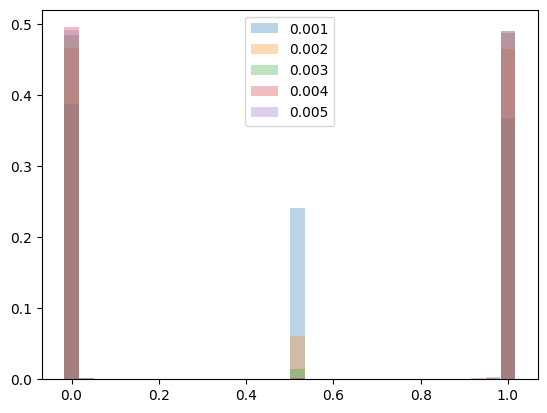

In [ ]:
alphas = [0.001, 0.002, 0.003, 0.004, 0.005]
for alpha in alphas: plot_beta(alpha)

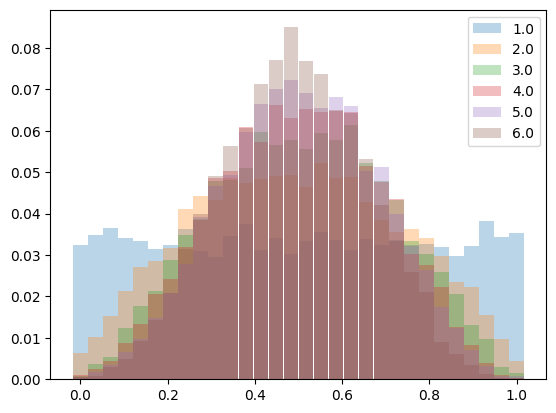

In [ ]:
alphas = torch.linspace(1, 6, 6)
for alpha in alphas: plot_beta(alpha)

## MixUP per batch

###  Model9 SILU

accuracy,loss,epoch,train
0.488,0.918,0,train
0.858,0.453,0,eval
0.484,0.704,1,train
0.903,0.328,1,eval
0.501,0.604,2,train
0.927,0.240,2,eval
0.505,0.542,3,train
0.936,0.203,3,eval
0.534,0.477,4,train
0.942,0.194,4,eval


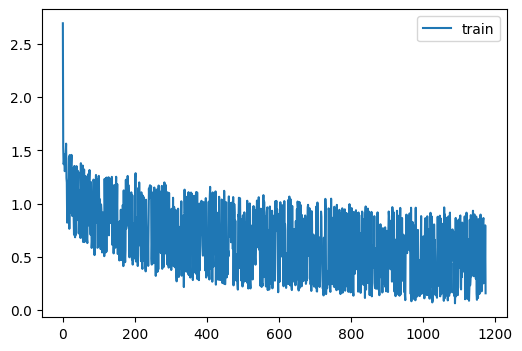

Fit 5 in: 113.66s, setup: 0.00s, 21.63 ± 0.11s per epoch, 0.01 ± 0.00s per batch


In [ ]:
set_seed(1)
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 5
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), MixUpCB(0.4)] 
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

accuracy,loss,epoch,train
0.473,0.888,0,train
0.894,0.355,0,eval
0.507,0.723,1,train
0.908,0.290,1,eval
0.498,0.625,2,train
0.919,0.262,2,eval
0.523,0.554,3,train
0.938,0.205,3,eval
0.522,0.486,4,train
0.942,0.194,4,eval


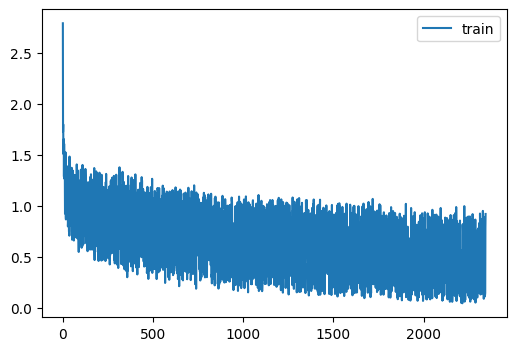

Fit 5 in: 121.96s, setup: 0.00s, 23.31 ± 0.14s per epoch, 0.01 ± 0.00s per batch


In [ ]:
dls = DataLoaders.from_dd(tds.cached, 128, num_workers=0)
set_seed(1)
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 5
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), MixUpCB(0.4)] 
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

accuracy,loss,epoch,train
0.488,0.976,0,train
0.841,0.589,0,eval
0.499,0.728,1,train
0.906,1.032,1,eval
0.525,0.658,2,train
0.926,0.989,2,eval
0.512,0.585,3,train
0.939,0.273,3,eval
0.533,0.531,4,train
0.943,0.205,4,eval


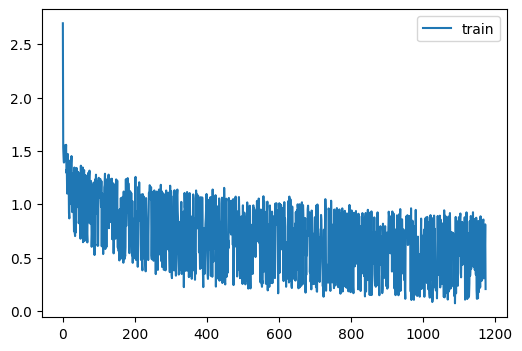

Fit 5 in: 113.34s, setup: 0.00s, 21.58 ± 0.12s per epoch, 0.01 ± 0.00s per batch


In [ ]:
set_seed(1)
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 5
lr = 1e-2
tmax = epochs * len(dls.train)
schedb = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), MixUpCB(0.5)] 
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

accuracy,loss,epoch,train
0.488,1.008,0,train
0.835,0.540,0,eval
0.479,0.766,1,train
0.907,0.295,1,eval
0.529,0.691,2,train
0.925,0.262,2,eval
0.521,0.635,3,train
0.936,0.240,3,eval
0.537,0.562,4,train
0.941,0.202,4,eval


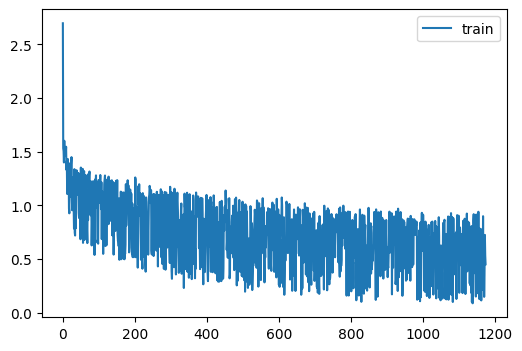

Fit 5 in: 113.26s, setup: 0.00s, 21.56 ± 0.12s per epoch, 0.01 ± 0.00s per batch


In [ ]:
set_seed(1)
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 5
lr = 1e-2
tmax = epochs * len(dls.train)
schedb = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), MixUpCB(0.6)] 
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

accuracy,loss,epoch,train
0.865,0.552,0,train
0.880,0.360,0,eval
0.907,0.293,1,train
0.912,0.256,1,eval
0.930,0.207,2,train
0.926,0.220,2,eval
0.952,0.144,3,train
0.939,0.184,3,eval
0.976,0.081,4,train
0.942,0.184,4,eval


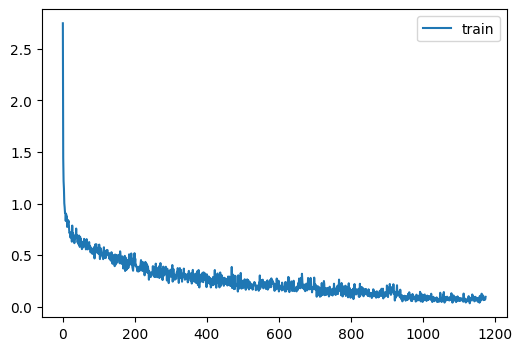

Fit 5 in: 113.26s, setup: 0.00s, 21.56 ± 0.10s per epoch, 0.01 ± 0.00s per batch


In [ ]:
set_seed(1)
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 5
lr = 1e-2
tmax = epochs * len(dls.train)
schedb = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), MixUpCB(None)] 
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

### Resnet SILU

Batch size 256


accuracy,loss,epoch,train
0.467,0.988,0,train
0.308,2.813,0,eval
0.493,0.694,1,train
0.868,0.380,1,eval
0.515,0.588,2,train
0.923,0.268,2,eval
0.572,0.583,3,train
0.938,0.202,3,eval
0.556,0.500,4,train
0.944,0.179,4,eval


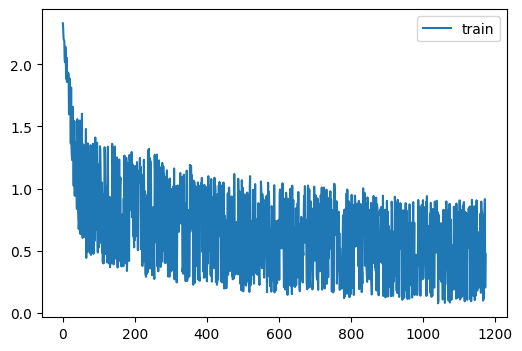

Fit 5 in: 138.60s, setup: 0.00s, 25.85 ± 0.07s per epoch, 0.03 ± 0.01s per batch
TTA: 0.8697


In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, 
            leaky=0.0003, cbs=[upscale_cb(4, 'bilinear')], train_cb=MixUpCB(0.4))

### Resnet SILU + aug

Batch size 256


accuracy,loss,epoch,train
0.445,1.045,0,train
0.821,0.508,0,eval
0.499,0.734,1,train
0.884,0.374,1,eval
0.513,0.643,2,train
0.908,0.263,2,eval
0.523,0.573,3,train
0.927,0.215,3,eval
0.527,0.528,4,train
0.937,0.189,4,eval


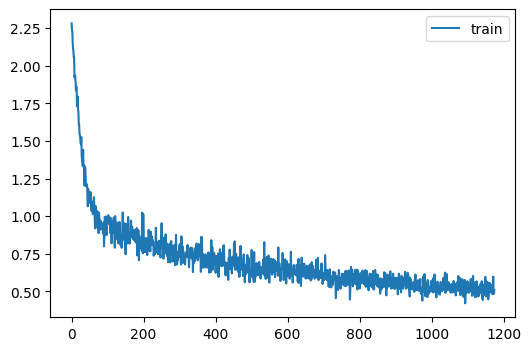

Fit 5 in: 139.45s, setup: 0.00s, 25.99 ± 0.01s per epoch, 0.03 ± 0.00s per batch
TTA: 0.9396


In [ ]:
tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, epochs=5,
            leaky=0.0003, cbs=[upscale_cb(4, 'bilinear'), augcb], train_cb=MixUpCB(0.4, mix_data=mixup_data2, mix_loss=lambda lf, p, l: lf(p,l)))

Batch size 256


accuracy,loss,epoch,train
0.471,1.025,0,train
0.701,1.138,0,eval
0.509,0.730,1,train
0.838,0.542,1,eval
0.516,0.634,2,train
0.900,0.353,2,eval
0.536,0.636,3,train
0.934,0.207,3,eval
0.523,0.524,4,train
0.943,0.174,4,eval


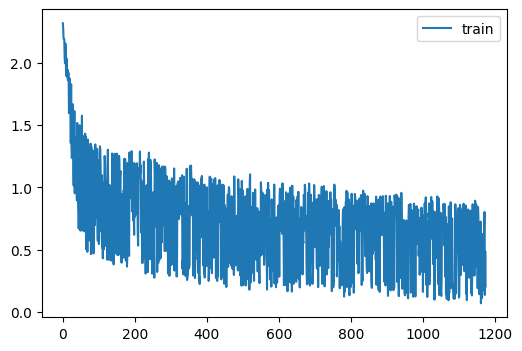

Fit 5 in: 139.01s, setup: 0.00s, 25.94 ± 0.02s per epoch, 0.03 ± 0.00s per batch
TTA: 0.8769


In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, 
            leaky=0.0003, cbs=[upscale_cb(4, 'bilinear')], train_cb=MixUpCB(0.5))

## MixUP per example SILU

accuracy,loss,epoch,train
0.479,0.929,0,train
0.869,0.406,0,eval
0.504,0.725,1,train
0.907,0.294,1,eval
0.510,0.637,2,train
0.920,0.252,2,eval
0.523,0.580,3,train
0.935,0.202,3,eval
0.534,0.526,4,train
0.939,0.187,4,eval


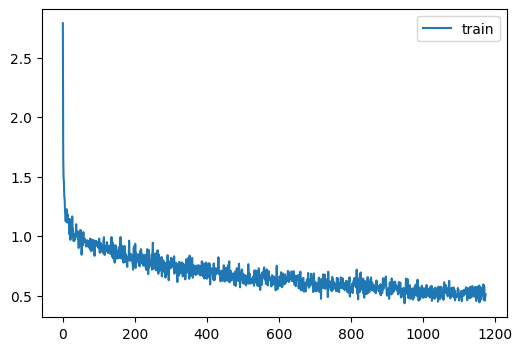

Fit 5 in: 113.33s, setup: 0.00s, 21.58 ± 0.10s per epoch, 0.01 ± 0.00s per batch


In [ ]:
set_seed(1)
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 5
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

# tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
#                      transforms.RandomHorizontalFlip(0.65))
# augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

xtra = [BatchSchedCB(sched), MixUpCB(0.4, mix_data=mixup_data2, mix_loss=lambda lf, p, l: lf(p,l))] 
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

accuracy,loss,epoch,train
0.463,1.012,0,train
0.858,0.438,0,eval
0.491,0.798,1,train
0.879,0.384,1,eval
0.504,0.701,2,train
0.907,0.289,2,eval
0.510,0.645,3,train
0.924,0.242,3,eval
0.521,0.598,4,train
0.928,0.217,4,eval


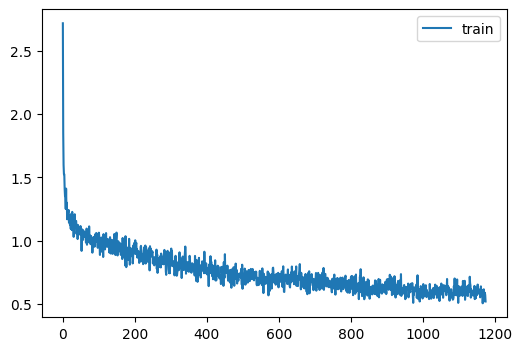

Fit 5 in: 114.54s, setup: 0.00s, 21.81 ± 0.03s per epoch, 0.01 ± 0.00s per batch


In [ ]:
set_seed(1)
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 5
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

xtra = [BatchSchedCB(sched), MixUpCB(0.4, mix_data=mixup_data2, mix_loss=lambda lf, p, l: lf(p,l)), augcb] 
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

accuracy,loss,epoch,train
0.479,0.929,0,train
0.869,0.406,0,eval
0.504,0.725,1,train
0.907,0.294,1,eval
0.510,0.637,2,train
0.919,0.252,2,eval
0.524,0.580,3,train
0.934,0.202,3,eval
0.534,0.526,4,train
0.938,0.187,4,eval


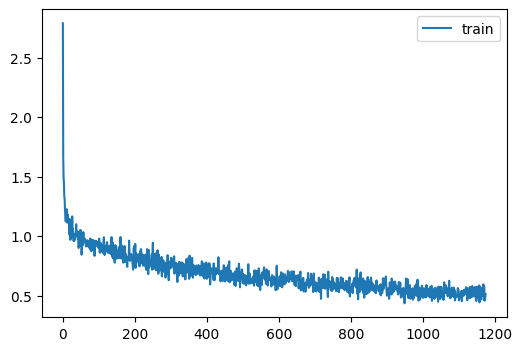

Fit 5 in: 114.21s, setup: 0.00s, 21.75 ± 0.08s per epoch, 0.01 ± 0.00s per batch


In [ ]:
set_seed(1)
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 5
lr = 1e-2
tmax = epochs * len(dls.train)
schedb = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), MixUpCB(0.4, mix_data=mixup_data2, mix_loss=lambda lf, p, l: lf(p,l))] 
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

## Decaying Mixup

In [ ]:
class DecayingMixUpCB(MixUpCB):
    def __init__(self, *args, decay=1.2, **kwargs):
        self.decay=decay
        super().__init__(*args, **kwargs)
    def before_batch(self, learn):
        super().before_batch(learn)
    def after_epoch(self, learn):
        if learn.training:
            self.alpha /= self.decay
            self.alpha = min(tensor(0.6), self.alpha)
            print('new alpha', self.alpha)
            

accuracy,loss,epoch,train
0.482,0.995,0,train
0.843,0.489,0,eval
0.500,0.767,1,train
0.892,0.336,1,eval
0.512,0.643,2,train
0.922,0.245,2,eval
0.523,0.548,3,train
0.936,0.198,3,eval
0.532,0.459,4,train
0.942,0.182,4,eval


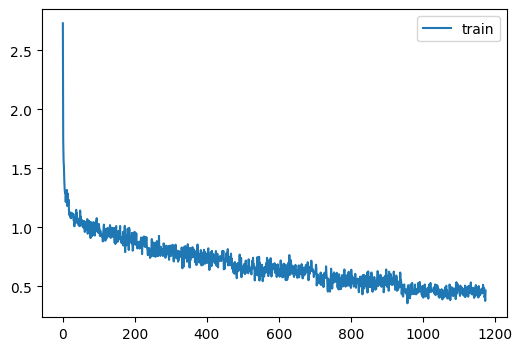

new alpha 0.5
new alpha 0.4166666666666667
new alpha 0.34722222222222227
new alpha 0.2893518518518519
new alpha 0.24112654320987661
Fit 5 in: 113.93s, setup: 0.00s, 21.69 ± 0.08s per epoch, 0.01 ± 0.00s per batch


In [ ]:
set_seed(1)
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 5
lr = 1e-2
tmax = epochs * len(dls.train)
schedb = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), DecayingMixUpCB(0.6, mix_data=mixup_data2, mix_loss=lambda lf, p, l: lf(p,l))] 
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

accuracy,loss,epoch,train
0.477,0.725,0,train
0.877,0.368,0,eval
0.498,0.525,1,train
0.899,0.320,1,eval
0.513,0.478,2,train
0.919,0.235,2,eval
0.524,0.452,3,train
0.934,0.195,3,eval
0.529,0.446,4,train
0.937,0.184,4,eval


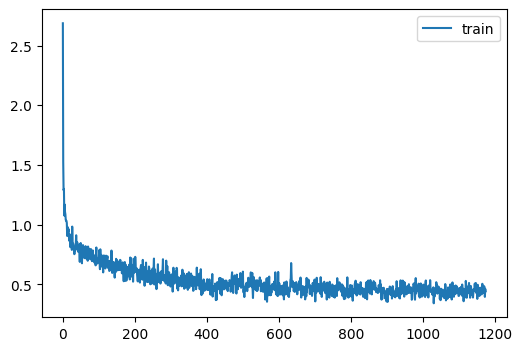

new alpha 0.125
new alpha 0.15625
new alpha 0.1953125
new alpha 0.244140625
new alpha 0.30517578125
Fit 5 in: 113.74s, setup: 0.00s, 21.66 ± 0.19s per epoch, 0.01 ± 0.01s per batch


In [ ]:
set_seed(1)
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 5
lr = 1e-2
tmax = epochs * len(dls.train)
schedb = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), DecayingMixUpCB(0.1, decay=0.8, mix_data=mixup_data2, mix_loss=lambda lf, p, l: lf(p,l))] 
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

accuracy,loss,epoch,train
0.479,0.971,0,train
0.882,0.389,0,eval
0.505,0.801,1,train
0.901,0.312,1,eval
0.518,0.756,2,train
0.916,0.266,2,eval
0.522,0.731,3,train
0.930,0.230,3,eval
0.530,0.687,4,train
0.936,0.209,4,eval


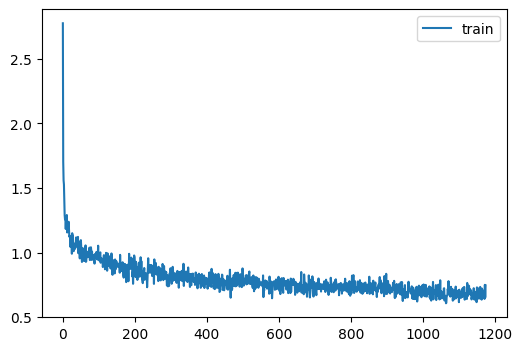

new alpha 0.625
new alpha 0.78125
new alpha 0.9765625
new alpha tensor(1.)
new alpha tensor(1.)
Fit 5 in: 114.39s, setup: 0.00s, 21.78 ± 0.05s per epoch, 0.01 ± 0.00s per batch


In [ ]:
set_seed(1)
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 5
lr = 1e-2
tmax = epochs * len(dls.train)
schedb = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), DecayingMixUpCB(0.5, decay=0.8, mix_data=mixup_data2, mix_loss=lambda lf, p, l: lf(p,l))] 
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

accuracy,loss,epoch,train
0.478,0.878,0,train
0.852,0.451,0,eval
0.503,0.715,1,train
0.906,0.286,1,eval
0.516,0.672,2,train
0.924,0.239,2,eval
0.523,0.650,3,train
0.936,0.207,3,eval
0.533,0.605,4,train
0.938,0.196,4,eval


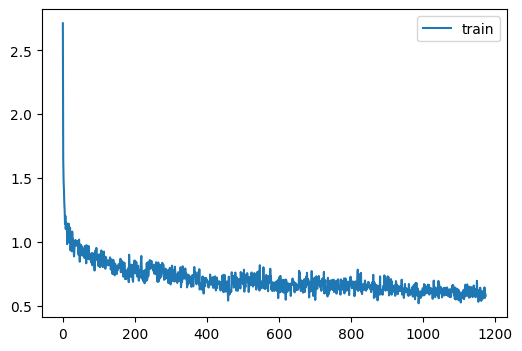

new alpha 0.37499999999999994
new alpha 0.4687499999999999
new alpha 0.5859374999999998
new alpha tensor(0.60)
new alpha tensor(0.60)
Fit 5 in: 114.34s, setup: 0.00s, 21.77 ± 0.05s per epoch, 0.01 ± 0.00s per batch


In [ ]:
set_seed(1)
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 5
lr = 1e-2
tmax = epochs * len(dls.train)
schedb = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), DecayingMixUpCB(0.3, decay=0.8, mix_data=mixup_data2, mix_loss=lambda lf, p, l: lf(p,l))] 
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

## 20 epochs SILU

### [93.8] Base no mixu/aug

accuracy,loss,epoch,train
0.869,0.590,0,train
0.884,0.512,0,eval
0.908,0.389,1,train
0.896,0.360,1,eval
0.918,0.287,2,train
0.894,0.332,2,eval
0.926,0.230,3,train
0.907,0.275,3,eval
0.937,0.188,4,train
0.911,0.256,4,eval


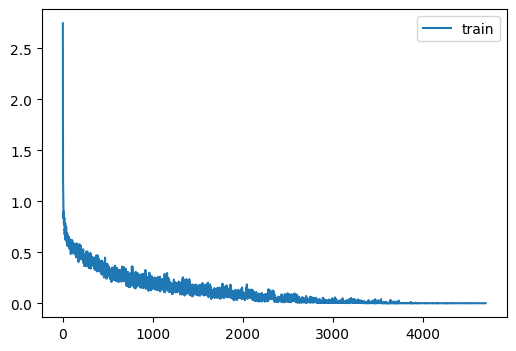

Fit 20 in: 455.11s, setup: 0.00s, 21.66 ± 0.15s per epoch, 0.01 ± 0.00s per batch


In [ ]:
set_seed(1)
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched),TrainCB()] 
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

### [94.7] Model9 Mixup 0.4

accuracy,loss,epoch,train
0.481,0.942,0,train
0.883,0.493,0,eval
0.504,0.788,1,train
0.900,0.363,1,eval
0.504,0.709,2,train
0.898,0.336,2,eval
0.513,0.663,3,train
0.910,0.287,3,eval
0.520,0.622,4,train
0.920,0.244,4,eval


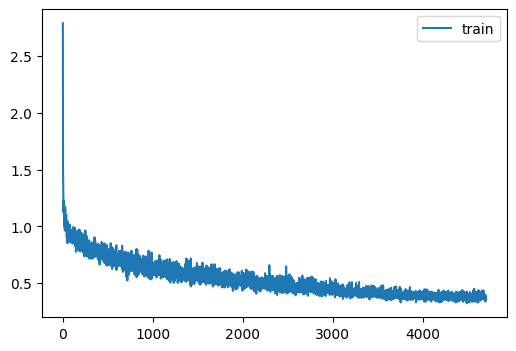

Fit 20 in: 461.09s, setup: 0.00s, 21.95 ± 0.01s per epoch, 0.01 ± 0.00s per batch


In [ ]:
set_seed(1)
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), MixUpCB(0.4, mix_data=mixup_data2, mix_loss=lambda lf, p, l: lf(p,l))] 
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

### [94.9] Model9 Mixup 0.4 + Aug

accuracy,loss,epoch,train
0.466,1.020,0,train
0.861,0.538,0,eval
0.489,0.854,1,train
0.879,0.435,1,eval
0.497,0.775,2,train
0.886,0.354,2,eval
0.501,0.725,3,train
0.894,0.315,3,eval
0.509,0.684,4,train
0.898,0.292,4,eval


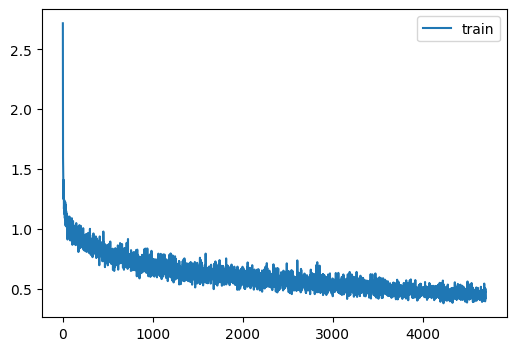

Fit 20 in: 460.28s, setup: 0.00s, 21.90 ± 0.02s per epoch, 0.01 ± 0.00s per batch


In [ ]:
set_seed(1)
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

xtra = [BatchSchedCB(sched), MixUpCB(0.4, mix_data=mixup_data2, mix_loss=lambda lf, p, l: lf(p,l)), augcb] 
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

### [95.1 T95.23] Model9 Mixup 0.5 + aug, bs=128

accuracy,loss,epoch,train
0.472,1.037,0,train
0.870,0.475,0,eval
0.492,0.883,1,train
0.877,0.397,1,eval
0.496,0.808,2,train
0.883,0.359,2,eval
0.501,0.767,3,train
0.905,0.292,3,eval
0.507,0.726,4,train
0.898,0.297,4,eval


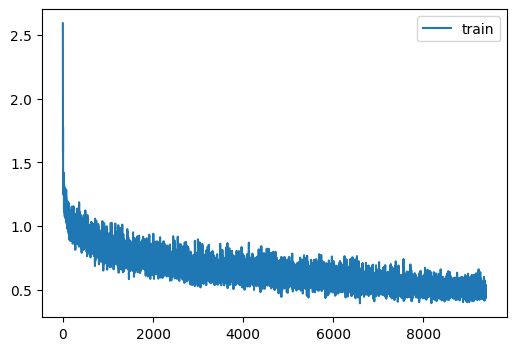

Fit 20 in: 497.37s, setup: 0.00s, 23.77 ± 0.04s per epoch, 0.01 ± 0.00s per batch


In [ ]:
dls = DataLoaders.from_dd(tds.cached, 128, num_workers=0)
set_seed(1)
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

xtra = [BatchSchedCB(sched), MixUpCB(0.5, mix_data=mixup_data2, mix_loss=lambda lf, p, l: lf(p,l)), augcb] 
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

accuracy,loss,epoch,train
0.951,0.154,0,eval


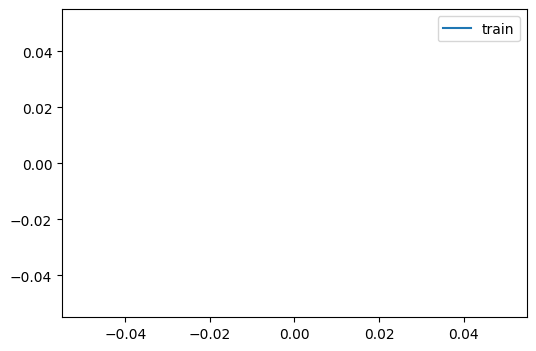

In [ ]:
ap1, at = learn.capture_preds()

accuracy,loss,epoch,train
0.951,0.151,0,eval


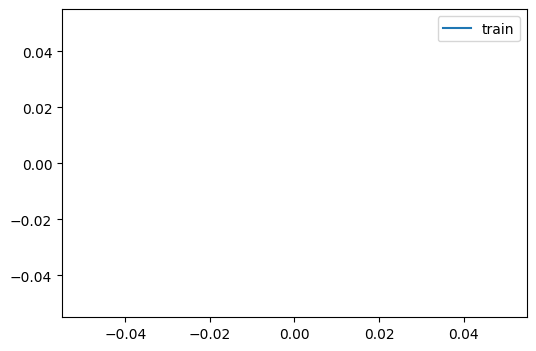

In [ ]:
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])

In [ ]:
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
round((ap==at).float().mean().item(), 4)

0.9523

### [94.9 T95.25] Resnet18d bilnear, mixup0.4, flip

Batch size 256


accuracy,loss,epoch,train
0.448,1.043,0,train
0.865,0.399,0,eval
0.499,0.745,1,train
0.834,0.546,1,eval
0.506,0.695,2,train
0.884,0.345,2,eval
0.515,0.653,3,train
0.897,0.349,3,eval
0.514,0.627,4,train
0.886,0.390,4,eval


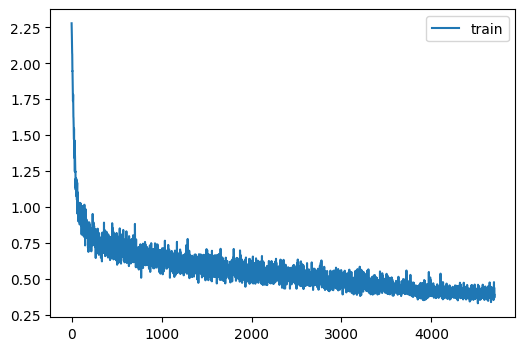

Fit 20 in: 557.34s, setup: 0.00s, 25.99 ± 0.04s per epoch, 0.03 ± 0.00s per batch
TTA: 0.9525


In [ ]:
tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, epochs=20,
            leaky=0.0003, cbs=[upscale_cb(4, 'bilinear'), augcb], train_cb=MixUpCB(0.4, mix_data=mixup_data2, mix_loss=lambda lf, p, l: lf(p,l)))

### [95 T95.19] Resnet18d nearest, mixup0.4, flip

Batch size 256


accuracy,loss,epoch,train
0.445,1.047,0,train
0.863,0.418,0,eval
0.500,0.740,1,train
0.887,0.361,1,eval
0.508,0.691,2,train
0.897,0.311,2,eval
0.515,0.646,3,train
0.889,0.335,3,eval
0.516,0.620,4,train
0.910,0.269,4,eval


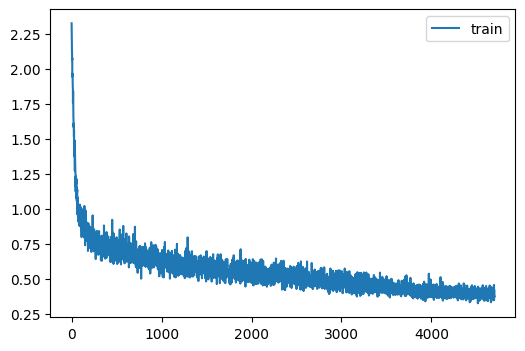

Fit 20 in: 559.01s, setup: 0.00s, 26.03 ± 0.03s per epoch, 0.03 ± 0.00s per batch
TTA: 0.9519


In [ ]:
tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, epochs=20,
            leaky=0.0003, cbs=[upscale_cb(4, 'nearest'), augcb], train_cb=MixUpCB(0.4, mix_data=mixup_data2, mix_loss=lambda lf, p, l: lf(p,l)))

In [ ]:
torch.save(learn.model, "20ep_resnet18d_mixup4")

### [94.9T95.25] Resnet18d bilnear, mixup0.4, flip Harswish, Dropout

Batch size 256


accuracy,loss,epoch,train
0.448,1.043,0,train
0.865,0.399,0,eval
0.499,0.745,1,train
0.834,0.546,1,eval
0.506,0.695,2,train
0.884,0.345,2,eval
0.515,0.653,3,train
0.897,0.349,3,eval
0.514,0.627,4,train
0.886,0.390,4,eval


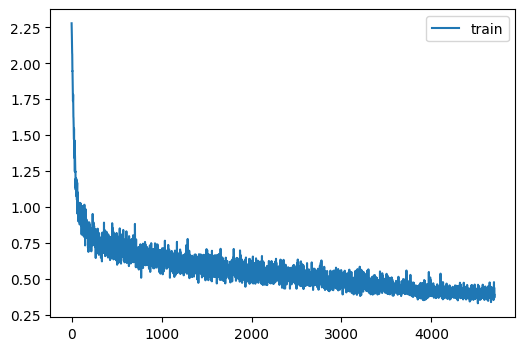

Fit 20 in: 557.34s, setup: 0.00s, 25.99 ± 0.04s per epoch, 0.03 ± 0.00s per batch
TTA: 0.9525


In [ ]:
tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, epochs=20,
            leaky=0.0003, cbs=[upscale_cb(4, 'bilinear'), augcb], train_cb=MixUpCB(0.4, mix_data=mixup_data2, mix_loss=lambda lf, p, l: lf(p,l)))

### [95 T95.17] Resenet34d

Batch size 256


accuracy,loss,epoch,train
0.430,1.101,0,train
0.873,0.409,0,eval
0.499,0.737,1,train
0.789,0.600,1,eval
0.508,0.679,2,train
0.893,0.325,2,eval
0.512,0.647,3,train
0.631,1.176,3,eval
0.513,0.631,4,train
0.783,0.569,4,eval


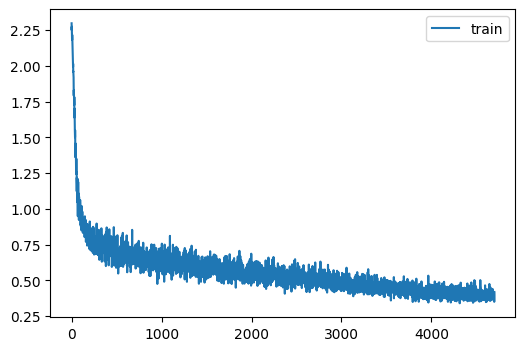

Fit 20 in: 1001.33s, setup: 0.00s, 47.58 ± 0.15s per epoch, 0.16 ± 0.01s per batch
TTA: 0.9517


In [ ]:
tfms = nn.Sequential(transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

learn = run(timm.create_model('resnet34d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, epochs=20,
            leaky=0.0003, cbs=[upscale_cb(4, 'bilinear'), augcb], train_cb=MixUpCB(0.4, mix_data=mixup_data2, mix_loss=lambda lf, p, l: lf(p,l)))

## 50 epochs

In [ ]:
cbs = [DeviceCB(), metrics, ProgressCB()] 

In [ ]:
dls = DataLoaders.from_dd(tds.cached, 128, num_workers=0)
set_seed(1)
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 50
lr = 1e-2

cbs = [DeviceCB(), metrics, ProgressCB()] 
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

xtra = [BatchSchedCB(sched), MixUpCB(0.5, mix_data=mixup_data2, mix_loss=lambda lf, p, l: lf(p,l)), augcb] 
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

accuracy,loss,epoch,train
0.474,1.035,0,train
0.876,0.503,0,eval
0.497,0.885,1,train
0.873,0.426,1,eval
0.498,0.824,2,train
0.889,0.381,2,eval
0.503,0.785,3,train
0.890,0.342,3,eval
0.508,0.745,4,train
0.896,0.309,4,eval


Fit 50 in: 1235.44s, setup: 0.00s, 23.70 ± 0.22s per epoch, 0.01 ± 0.01s per batch


In [ ]:
ap1, at = learn.capture_preds()

accuracy,loss,epoch,train
0.954,0.178,0,eval


In [ ]:
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])

accuracy,loss,epoch,train
0.956,0.168,0,eval


In [ ]:
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
round((ap==at).float().mean().item(), 4)

0.957

In [ ]:
torch.save(learn.model, "50ep_model9_mixup5")

### Model9 50 epochs mixup 0.4, aug

In [ ]:
set_seed(1)
act_gr = nn.SiLU
iw = partial(init_weights, leaky=0.0003)
epochs = 50
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(0.65))
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

xtra = [BatchSchedCB(sched), MixUpCB(0.4, mix_data=mixup_data2, mix_loss=lambda lf, p, l: lf(p,l)), augcb] 
model = get_model9(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs, cbs=TimeItCB())

accuracy,loss,epoch,train
0.468,1.000,0,train
0.877,0.470,0,eval
0.494,0.847,1,train
0.886,0.395,1,eval
0.497,0.783,2,train
0.888,0.362,2,eval
0.501,0.743,3,train
0.901,0.322,3,eval
0.511,0.706,4,train
0.905,0.289,4,eval


Fit 50 in: 1235.70s, setup: 0.00s, 23.70 ± 0.01s per epoch, 0.01 ± 0.00s per batch


In [ ]:
ap1, at = learn.capture_preds()

accuracy,loss,epoch,train
0.954,0.183,0,eval


In [ ]:
ttacb = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_val=True)
ap2, at = learn.capture_preds(cbs=[ttacb])

accuracy,loss,epoch,train
0.955,0.179,0,eval


In [ ]:
ap = torch.stack([ap1,ap2]).mean(0).argmax(1)
round((ap==at).float().mean().item(), 4)

0.957

In [ ]:
torch.save(learn.model, "50ep_model9_mixup4")

In [ ]:
sz = 10000

x = torch.linspace(0, 1, 10)
alphas = torch.linspace(0.001, 1, 5)
for alpha in alphas:
    dist = torch.distributions.Beta(alpha,alpha)
    histc = dist.sample([sz]).histc(bins=x.shape[-1])/sz
    plt.bar(x, histc, width=0.1, alpha=0.3, label='a')
    plt.legend([f'{v:.3}' for v in alphas])

In [ ]:
histc

tensor([148.,  97.,  97.,  96.,  70.,  85.,  99.,  91., 104., 113.])

In [ ]:
x

tensor([0.00, 0.11, 0.22, 0.33, 0.44, 0.56, 0.67, 0.78, 0.89, 1.00])